# Установка библиотек и импорт модулей

In [1]:
!pip install -q gymnasium atari-py gymnasium[atari] gymnasium[accept-rom-license] wandb
!pip install -q stable-baselines3[extra]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 34.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 6.0 MB/s eta 0:00:00


In [2]:
import gym
import wandb

import numpy as np

import gymnasium as gym
from gymnasium.wrappers import FrameStack

import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_atari_env, make_vec_env


In [3]:
import warnings

# Бесят эти предупреждения об устаревании

warnings.filterwarnings('ignore', category=DeprecationWarning)


# Реализация DQN для игры Pong

In [18]:
env = make_atari_env('PongNoFrameskip-v4', n_envs=4)


In [19]:
obs = env.reset()



(84, 84, 1)


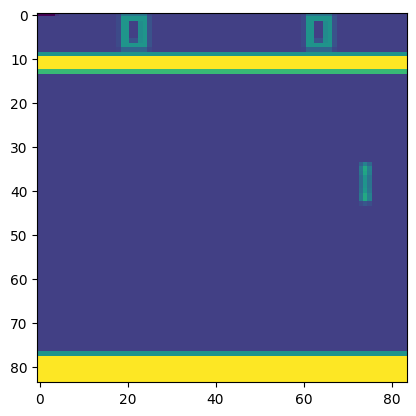

In [20]:
plt.imshow(obs[0])
print()
print(obs[0].shape)


In [21]:
# Получение информации о среде
print(env.observation_space)
print(env.action_space)


Box(0, 255, (84, 84, 1), uint8)
Discrete(6)


In [4]:
!wandb login
wandb.init(
    project="DQN_Atari",
    entity='Senich17')


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: senich17. Use `wandb login --relogin` to force relogin


In [5]:
class WandbCustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(WandbCustomCallback, self).__init__(verbose)

        self.step = 0

    def _on_step(self) -> bool:
        # Логирование метрик на каждом шаге
        self.step += 1
        # Получаем последние значения среды (награды, информацию и т.д.)
        infos = self.locals["infos"]

        for info in infos:
            if "episode" in info.keys():
                # Логируем суммарную награду и длину эпизода
                wandb.log({"reward": info["episode"]["r"], "length": info["episode"]["l"]}, step=self.step)

        return True


In [ ]:
env.reset()


In [23]:
# Создание модели
model = DQN("CnnPolicy", env, verbose=1, learning_rate=0.0001, buffer_size=20000, gamma=0.99)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [24]:
# Создание экземпляра обратного вызова с передачей модели
callback = WandbCustomCallback(model)


In [25]:
# Обучение модели с использованием обратного вызова
model.learn(total_timesteps=1000000, callback=callback)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83e+03 |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.96     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 596      |
|    time_elapsed     | 7        |
|    total_timesteps  | 4224     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000149 |
|    n_updates        | 257      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16e+03 |
|    ep_rew_mean      | -19.9    |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 558      |
|    time_elapsed     | 15       |
|    total_timesteps  | 8648     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000196 |
|    n_updates      

In [26]:
# Оценка политики
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"Mean Reward: {mean_reward} +/- {std_reward}")


Mean Reward: -17.9 +/- 1.4456832294800963


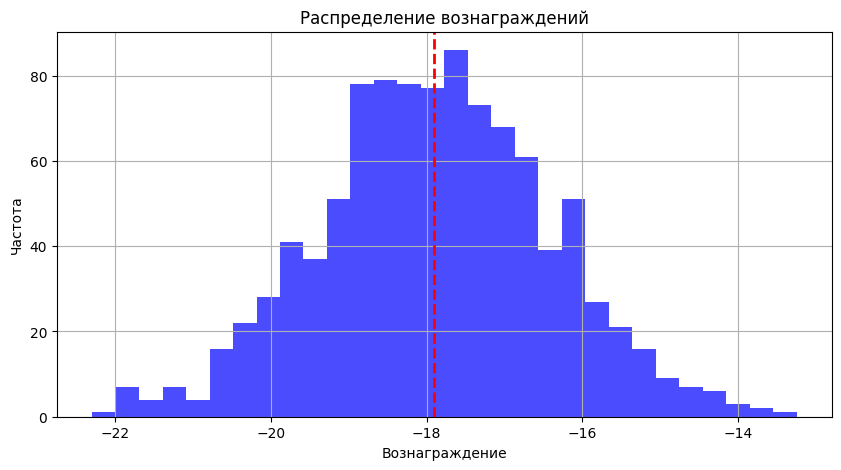

In [27]:
mean_reward = -17.9 # это среднее значение награды, полученное моделью за каждый эпизод на тестовом наборе эпизодов.
std_reward = 1.45 # это стандартное отклонение, которое показывает разброс значений награды в тестовом наборе эпизодов.

# Создаем массив значений для наглядности ошибки
rewards = np.random.normal(loc=mean_reward, scale=std_reward, size=1000)

# Визуализация среднего вознаграждения с использованием гистограммы
plt.figure(figsize=(10, 5))
plt.hist(rewards, bins=30, color='blue', alpha=0.7)
plt.axvline(x=mean_reward, color='red', linestyle='dashed', linewidth=2)
plt.title('Распределение вознаграждений')
plt.xlabel('Вознаграждение')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


In [ ]:
# Загрузка модели (необязательно, если мы сразу переходим к оценке)
#model = DQN.load("dqn_pong")


In [59]:
model.save("dqn_pong")


In [60]:
# Закрытие среды
env.close()


Так же прилагаю ссылку на отчет сформированный wandb

https://api.wandb.ai/links/senich17/wiqcdmh4

# Реализация DQN для игры Boxing

In [6]:
env = make_atari_env('BoxingNoFrameskip-v4', n_envs=4)


In [7]:
obs = env.reset()



(84, 84, 1)


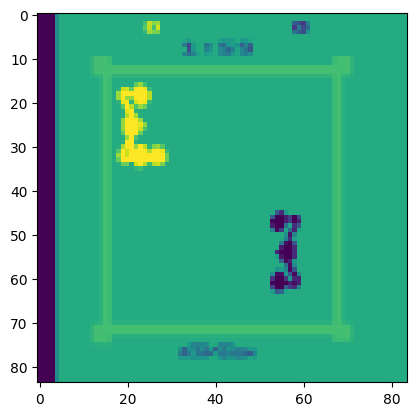

In [8]:
plt.imshow(obs[0])
print()
print(obs[0].shape)


In [10]:
# Получение информации о среде
print(env.observation_space)
print(env.action_space)


Box(0, 255, (84, 84, 1), uint8)
Discrete(18)


In [12]:
# Создание модели
model = DQN("CnnPolicy", env, verbose=1, learning_rate=0.0001, buffer_size=20000, gamma=0.99)


Using cuda device
Wrapping the env in a VecTransposeImage.


In [13]:
# Создание экземпляра обратного вызова с передачей модели
callback = WandbCustomCallback(model)


In [14]:
# Обучение модели с использованием обратного вызова
model.learn(total_timesteps=1000000, callback=callback)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.14e+03 |
|    ep_rew_mean      | -3.75    |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 451      |
|    time_elapsed     | 15       |
|    total_timesteps  | 7120     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000132 |
|    n_updates        | 438      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.14e+03 |
|    ep_rew_mean      | -2.75    |
|    exploration_rate | 0.865    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 463      |
|    time_elapsed     | 30       |
|    total_timesteps  | 14244    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates      

In [15]:
# Оценка политики
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"Среднее вознаграждение: {mean_reward} +/- {std_reward}")


Среднее вознаграждение: 12.8 +/- 9.35735005223167


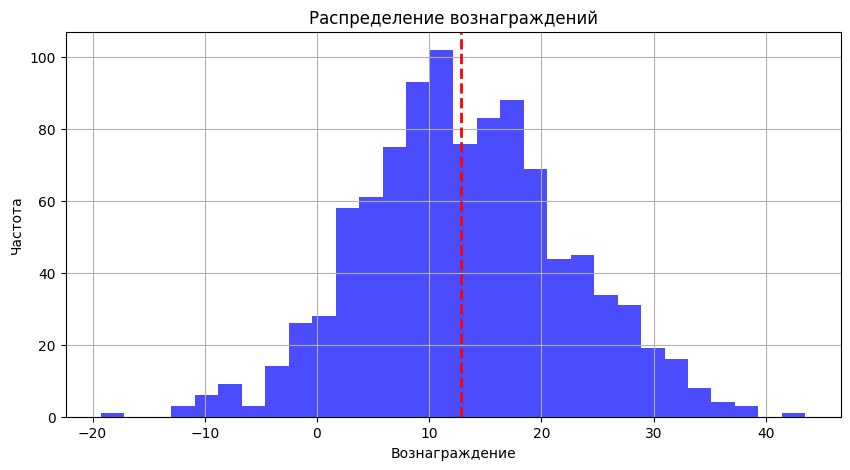

In [16]:
mean_reward = 12.8
std_reward = 9.36

# Создаем массив значений для наглядности ошибки
rewards = np.random.normal(loc=mean_reward, scale=std_reward, size=1000)

# Визуализация среднего вознаграждения с использованием гистограммы
plt.figure(figsize=(10, 5))
plt.hist(rewards, bins=30, color='blue', alpha=0.7)
plt.axvline(x=mean_reward, color='red', linestyle='dashed', linewidth=2)
plt.title('Распределение вознаграждений')
plt.xlabel('Вознаграждение')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


In [17]:
model.save("dqn_boxing")

Так же прилагаю ссылку на отчет сформированный wandb

https://api.wandb.ai/links/senich17/q05dabox

## Вывод по гиперпараметрам

###Learning rate
Высокое значение:

* Быстрая сходимость: Модель может быстро сходиться в начале обучения, что полезно, когда нужно быстро получить работающую модель.
* Нестабильность: Может возникнуть нестабильность в процессе обучения, проявляющаяся в виде колебаний или даже расходжения функции потерь.
* Пропуск оптимальных решений: Слишком большие шаги могут привести к тому, что модель будет "перепрыгивать" через оптимальные точки.

Низкий learning_rate:
* Стабильность: Обеспечивает более стабильное обучение, с меньшими колебаниями в процессе.
* Медленная сходимость: Может существенно замедлить процесс обучения, что неэффективно в условиях ограниченных ресурсов.
* Риск застревания в локальных минимумах: При очень низком learning_rate существует риск, что модель застрянет в локальном минимуме и не достигнет лучшего решения.

###Buffer size:

Параметр buffer_size определяет количество последних переходов (состояние, действие, вознаграждение, новое состояние), которые сохраняются для последующего обучения. Он отвечает за explotation опыта агента, поэтому необходимо четко соблюсьти между ним и эпсилоном.

В моем случае я столкнутась с тем, что агент показывает неплохой результат в самом начале, но со временем его производительность ухудшается, это может быть признаком переобучения, а иногда это происходит потому, что в самом начале игры, пока накапливается буффер, действия в игре выполняются случайным образом (потому как ангент должен совершить действие, не имея никакого опыта).

Так же необходимо иметь в виду, что слишком маленький объем буфера ограничивает количество данных, доступных для обучения, что приводит к быстрому "забыванию" предыдущих опытов и увеличению вероятности переобучения на последних взаимодействиях (влияние этого на поведение и показатели можно заметить, когда значение replay buffer=100 например).

В таком случае я значительно увеличила размер replay buffer, чтобы у агента было больше разнообразных примеров для обучения. И если буфер содержит большое количество опыта, вероятность того, что агент будет многократно тренироваться на одних и тех же данных, уменьшается. Это способствует лучшему исследованию пространства состояний и действий.

Но конечно важно иметь в виду, что обработка большего количества данных может увеличить время, необходимое для обучения, поскольку каждый пакет данных, в свою очередь, требует больше времени для обработки.

Небольшой buffer_size:

* Быстрое обучение: Агент быстрее обучается, так как обучение происходит на меньшем количестве данных, что требует меньше времени на обработку.
* Риск переобучения: Агент может начать переобучаться на часто встречающихся примерах в буфере, что ухудшит его способность генерализовать поведение в новых или редко встречающихся ситуациях.
* Нестабильность обучения: Обучение может стать более нестабильным, если опыт в буфере не достаточно представителен для всего пространства состояний.

Большoй buffer_size:

* Стабильность обучения: Обучение становится более стабильным за счет использования более разнообразного и представительного набора данных.
* Уменьшение переобучения: Больший буфер снижает вероятность переобучения, поскольку агент использует более широкий и разнообразный набор опытов для обучения.
* Увеличение времени обучения: Обработка большего количества данных может увеличить время, необходимое для обучения, поскольку каждый пакет данных требует больше времени для обработки. (Это просто иногда невероятно долго!)

В данной работе я пыталась выбрать вручную гиперпараметры, чтобы оценить насколько сильно они влияют на обучение агента, но пришла к неутешительному выводу, что подбор значений и их заметное влияние, можно оценить играя в долгую, в ОЧЕНЬ долгую :)

В моем случае это заняло 1.000.000 шагов (при этом гиперпараметры стояли по умолчанию!)
